# SocioPatterns

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import igraph as ig
import dionysus as d

In [3]:
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = 10, 6

In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
d.__version__

'2.0.7.dev0'

## Data import

In [5]:
g = ig.read("data/sociopatterns/infectious/infectious.graphml")

In [6]:
g.summary()

'IGRAPH UN-- 10972 415912 -- \n+ attr: id (v), name (v), id (e), time (e)'

In [10]:
(max(g.es["time"]) - min(g.es["time"])) // (3600 * 24)

80.0

## Temporal partitioning

In [43]:
from zigzag import *

In [44]:
wins = sliding_windows(g, 0.05)

In [46]:
len(wins)

20

## Zigzag persistence

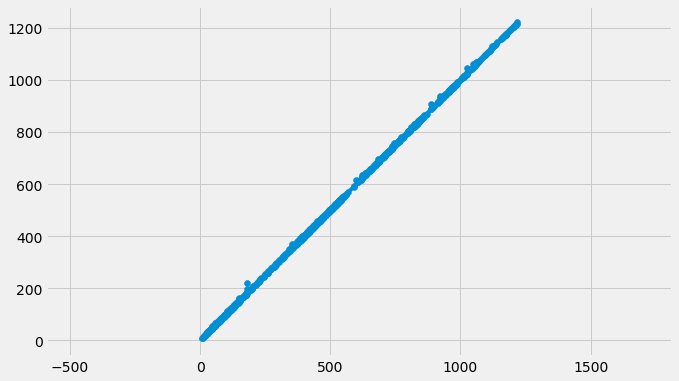

In [12]:
for w in wins[0:1]:
    (f, t) = presence_times(w)
    zz, dgms, cells = d.zigzag_homology_persistence(f, t)
    d.plot.plot_diagram(dgms[0])

In [ ]:
d.plot.plot_diagram(dgms[1])

In [47]:
import multiprocessing

In [ ]:
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
dgms = pool.map(zigzag_network, wins)

In [ ]:
pool.terminate()

## Sliced Wasserstein kernel

In [14]:
dgms0 = [dgm[0] for dgm in dgms if dgm != []]

In [20]:
dgms1 = [dgm[1] for dgm in dgms if len(dgm) > 1]

In [15]:
from sliced_wasserstein import diagram_array, SW_approx

In [16]:
gram0 = np.array([[SW_approx(dgms0[i], dgms0[j], 10) for i in range(len(dgms0))] for j in range(len(dgms0))])
gram0

array([[      0.        ,  168498.26575157,  142213.96446884, ...,
         181004.87138341,  980779.00902599,  604002.56924413],
       [ 168498.26575157,       0.        ,  108974.83210031, ...,
         292878.72367602,  864985.91166401,  466984.82235283],
       [ 142213.96446884,  108974.83210031,       0.        , ...,
         223518.93608983,  951003.34397253,  553228.56514372],
       ...,
       [ 181004.87138341,  292878.72367602,  223518.93608983, ...,
              0.        , 1153158.29742231,  755045.92126984],
       [ 980779.00902599,  864985.91166401,  951003.34397253, ...,
        1153158.29742231,       0.        ,  607164.48834291],
       [ 604002.56924413,  466984.82235283,  553228.56514372, ...,
         755045.92126984,  607164.48834291,       0.        ]])

In [23]:
gram1 = np.array([[SW_approx(dgms1[i], dgms1[j], 10) for i in range(len(dgms1))] for j in range(len(dgms1))])
gram1

array([[   0.        , 1782.59876486, 1976.144841  , ..., 1674.27089231,
        4008.08473571, 3074.53612959],
       [1782.59876486,    0.        ,  814.44479983, ..., 1389.37805531,
        3609.13022428, 1694.74694713],
       [1976.144841  ,  814.44479983,    0.        , ..., 1665.50397679,
        4034.59792213, 2097.51910373],
       ...,
       [1674.27089231, 1389.37805531, 1665.50397679, ...,    0.        ,
        2953.12379337, 1952.36875879],
       [4008.08473571, 3609.13022428, 4034.59792213, ..., 2953.12379337,
           0.        , 3326.13065883],
       [3074.53612959, 1694.74694713, 2097.51910373, ..., 1952.36875879,
        3326.13065883,    0.        ]])

In [36]:
def dgm2array(dgm):
    return np.array([[p.birth, p.death] for p in dgm])

In [29]:
from sklearn_tda import SlicedWasserstein

## Bottleneck distance

In [50]:
from dask.distributed import Client

In [ ]:
client = Client()
distmat = []
for dgm in dgms0:
    distmat.append(client.map(lambda x: d.bottleneck_distance(x, dgm), dgms0))

In [104]:
distmat = np.array(client.gather(distmat))
distmat

array([[ 0.        , 37.67822266, 71.04492188, ...,         inf,
                inf, 19.10028076],
       [37.69311523,  0.        , 70.44287109, ...,         inf,
                inf, 37.14916992],
       [70.62719727, 70.30273438,  0.        , ...,         inf,
                inf, 69.04138184],
       ...,
       [        inf,         inf,         inf, ...,  0.        ,
                inf,         inf],
       [        inf,         inf,         inf, ...,         inf,
         0.        ,         inf],
       [19.10028076, 37.14916992, 69.04138184, ...,         inf,
                inf,  0.        ]])

## Clustering

In [25]:
from sklearn.svm import OneClassSVM

/home/lozeve/.local/share/virtualenvs/tda-networks--KypeAmE/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/lozeve/.local/share/virtualenvs/tda-networks--KypeAmE/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/lozeve/.local/share/virtualenvs/tda-networks--KypeAmE/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/lozeve/.local/share/virtualenvs/tda-networks--KypeAmE/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [26]:
clf = OneClassSVM(kernel='precomputed')

In [22]:
(clf.predict(gram)+1)//2

array([1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1])

In [24]:
from sklearn.cluster import AgglomerativeClustering

In [25]:
gram1 = 1/gram1
gram1[gram1 == np.inf] = 0

/home/lozeve/.local/share/virtualenvs/tda-networks--KypeAmE/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [26]:
clf = AgglomerativeClustering(n_clusters=2, affinity="precomputed", linkage="complete")

In [27]:
clf.fit(gram1)

AgglomerativeClustering(affinity='precomputed', compute_full_tree='auto',
            connectivity=None, linkage='complete', memory=None,
            n_clusters=2, pooling_func=<function mean at 0x7f3dd41c29d8>)

In [28]:
clf.fit(gram1)
clf.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [105]:
distmat[distmat==np.inf] = 1e100

In [106]:
clf.fit(distmat)
clf.labels_

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1])